# Business Understanding

**Problema**: ¿Cómo podemos identificar a los clientes con mayor riesgo de abandono para intervenir de forma proactiva y reducir la tasa de cancelación?
**Hipotesis**: 
- Los clientes con contratos mensuales tienen mayor probabilidad de abandonar que aquellos con contratos a largo plazo.

- El uso de métodos de pago electrónicos automáticos se asocia a una menor tasa de cancelación.

- Clientes con múltiples servicios (internet + teléfono) tienen menor tasa de abandono debido a una mayor dependencia del proveedor.

- Los clientes mayores de 60 años tienen una menor propensión a cancelar su suscripción.

- Una factura mensual más elevada puede estar asociada a una mayor probabilidad de cancelación, especialmente si no hay valor percibido adicional.

**KPI**:
- F1-Score: balance entre precisión y recall.

- AUC-ROC: capacidad del modelo para discriminar entre clases.

Negocio:
- Reducción de la tasa de cancelación: diferencia porcentual antes y después de aplicar las acciones basadas en el modelo.

- Retorno de la inversión (ROI) de promociones: relación entre el costo de los códigos promocionales entregados y los ingresos conservados.

- Tasa de retención de clientes en riesgo: porcentaje de clientes en riesgo que permanecen tras recibir una oferta personalizada.

# Data Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
contract = pd.read_csv('../data/contract.csv')
internet = pd.read_csv('../data/internet.csv')
personal = pd.read_csv('../data/personal.csv')
phone = pd.read_csv('../data/phone.csv')

In [3]:
def exploracion_inicial(df):
    # Head
    print('-'*30 + 'Primeras 10 filas' + '-'*30)
    print(df.head(10))
    # Estructura de la tabla
    print('-'*30 + 'Estructura de la tabla' + '-'*30)
    print(df.info())
    # Duplicados
    print('-'*30 + 'Duplicados' + '-'*30)
    print(df.duplicated().sum())
    # Valores nulos
    print('-'*30 + 'Valores nulos' + '-'*30)
    print(df.isnull().sum())
    # Estadísticas
    print('-'*30 + 'Estadísticas' + '-'*30)
    print(df.describe())

In [4]:
exploracion_inicial(contract)

------------------------------Primeras 10 filas------------------------------
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
5  9305-CDSKC  2019-03-01  2019-11-01 00:00:00  Month-to-month   
6  1452-KIOVK  2018-04-01                   No  Month-to-month   
7  6713-OKOMC  2019-04-01                   No  Month-to-month   
8  7892-POOKP  2017-07-01  2019-11-01 00:00:00  Month-to-month   
9  6388-TABGU  2014-12-01                   No        One year   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed c

In [5]:
exploracion_inicial(internet)

------------------------------Primeras 10 filas------------------------------
   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   
5  9305-CDSKC     Fiber optic             No           No              Yes   
6  1452-KIOVK     Fiber optic             No          Yes               No   
7  6713-OKOMC             DSL            Yes           No               No   
8  7892-POOKP     Fiber optic             No           No              Yes   
9  6388-TABGU             DSL            Yes          Yes               No   

  TechSupport StreamingTV StreamingMovies  
0          No      

In [6]:
exploracion_inicial(personal)

------------------------------Primeras 10 filas------------------------------
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No
5  9305-CDSKC  Female              0      No         No
6  1452-KIOVK    Male              0      No        Yes
7  6713-OKOMC  Female              0      No         No
8  7892-POOKP  Female              0     Yes         No
9  6388-TABGU    Male              0      No        Yes
------------------------------Estructura de la tabla------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-nu

In [7]:
exploracion_inicial(phone)

------------------------------Primeras 10 filas------------------------------
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes
5  7892-POOKP           Yes
6  6388-TABGU            No
7  9763-GRSKD            No
8  7469-LKBCI            No
9  8091-TTVAX           Yes
------------------------------Estructura de la tabla------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
------------------------------Duplicados------------------------------
0
------------------------------Valores nulos------------------------------
customerID       0
MultipleLines    0
dtype: int64
---------

# Data Preparation

In [8]:
# Unificación de fuentes
data = pd.merge(contract, internet, on='customerID', how='left')
data.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [9]:
data = pd.merge(data, personal, on='customerID', how='left')
data.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents'],
      dtype='object')

In [10]:
data = pd.merge(data, phone, on='customerID', how='left')
data.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines'],
      dtype='object')

In [11]:
exploracion_inicial(data)

------------------------------Primeras 10 filas------------------------------
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
5  9305-CDSKC  2019-03-01  2019-11-01 00:00:00  Month-to-month   
6  1452-KIOVK  2018-04-01                   No  Month-to-month   
7  6713-OKOMC  2019-04-01                   No  Month-to-month   
8  7892-POOKP  2017-07-01  2019-11-01 00:00:00  Month-to-month   
9  6388-TABGU  2014-12-01                   No        One year   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed

In [12]:
cols_servicios = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in cols_servicios:
    data[col] = data[col].fillna('No')

In [13]:
data['MultipleLines'] = data['MultipleLines'].fillna('No phone service')

In [14]:
# Ver nulos
print(data.isnull().sum())

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64


In [15]:
# estructura de la tabla
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [16]:
# Pasar a fecha BeginDate y EndDate
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')

In [17]:
# Para EndDate si no es no pasar a fecha
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [18]:
data['EndDate'].isnull().sum()

5174

In [19]:
data_ml = data.copy()

In [20]:
data_ml['Type'].value_counts()

Type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [21]:
from sklearn.preprocessing import OrdinalEncoder

type_order = [['Month-to-month', 'One year', 'Two year']]
encoder = OrdinalEncoder(categories=type_order)

data_ml['Type_encoded'] = encoder.fit_transform(data_ml[['Type']])
data_ml.drop('Type', axis=1, inplace=True)

In [22]:
data_ml['PaperlessBilling'] = data_ml['PaperlessBilling'].map({'Yes': 1, 'No': 0})

In [23]:
data_ml['PaymentMethod'].value_counts()

PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

In [24]:
payment_dummy = pd.get_dummies(data_ml['PaymentMethod'], prefix='PaymentMethod')
data_ml = pd.concat([data_ml, payment_dummy], axis=1)
data_ml.drop('PaymentMethod', axis=1, inplace=True)

In [25]:
data_ml['TotalCharges'] = pd.to_numeric(data_ml['TotalCharges'], errors='coerce')
data_ml['TotalCharges'] = data_ml['TotalCharges'].fillna(0)


In [26]:
# Dummies de InternetService
data_ml = pd.get_dummies(data_ml, columns=['InternetService'], drop_first=False)

In [27]:
data_ml.drop('InternetService_No', axis=1, inplace=True)

In [28]:
# Transforma a boolean OnlineSecurity
data_ml['OnlineSecurity'] = data_ml['OnlineSecurity'].map({'Yes': 1, 'No': 0})

In [29]:
data_ml['OnlineBackup'] = data_ml['OnlineBackup'].map({'Yes': 1, 'No': 0})

In [30]:
data_ml['DeviceProtection'] = data_ml['DeviceProtection'].map({'Yes': 1, 'No': 0})

In [31]:
data_ml['TechSupport'] = data_ml['TechSupport'].map({'Yes': 1, 'No': 0})

In [32]:
data_ml['StreamingTV'] = data_ml['StreamingTV'].map({'Yes': 1, 'No': 0})

In [33]:
data_ml['StreamingMovies'] = data_ml['StreamingMovies'].map({'Yes': 1, 'No': 0})

In [34]:
data_ml['gender'].value_counts()

gender
Male      3555
Female    3488
Name: count, dtype: int64

In [35]:
# Si gender Male 0 si gender Female 1
data_ml['gender'] = data_ml['gender'].map({'Male': 0, 'Female': 1})

In [36]:
data_ml['Partner'] = data_ml['Partner'].map({'Yes': 1, 'No': 0})

In [37]:
data_ml['Dependents'] = data_ml['Dependents'].map({'Yes': 1, 'No': 0})

In [38]:
data_ml = pd.get_dummies(data_ml, columns=['MultipleLines'], drop_first=False)

In [39]:
data_ml.drop('MultipleLines_No phone service', axis=1, inplace=True)

In [40]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   customerID                               7043 non-null   object        
 1   BeginDate                                7043 non-null   datetime64[ns]
 2   EndDate                                  1869 non-null   datetime64[ns]
 3   PaperlessBilling                         7043 non-null   int64         
 4   MonthlyCharges                           7043 non-null   float64       
 5   TotalCharges                             7043 non-null   float64       
 6   OnlineSecurity                           7043 non-null   int64         
 7   OnlineBackup                             7043 non-null   int64         
 8   DeviceProtection                         7043 non-null   int64         
 9   TechSupport                              

In [41]:
data_ml['is_churn'] = data_ml['EndDate'].apply(lambda x: 1 if pd.notnull(x) else 0)


In [42]:
data_ml['is_churn'].value_counts()

is_churn
0    5174
1    1869
Name: count, dtype: int64

In [43]:
# Duration 
data_ml['Duration'] = (data_ml['EndDate'] - data_ml['BeginDate']).dt.days / 30

In [44]:
data_ml['Duration'].describe()  

count    1869.000000
mean       18.245069
std        19.812987
min         1.000000
25%         2.033333
50%        10.133333
75%        29.433333
max        73.033333
Name: Duration, dtype: float64

In [45]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   customerID                               7043 non-null   object        
 1   BeginDate                                7043 non-null   datetime64[ns]
 2   EndDate                                  1869 non-null   datetime64[ns]
 3   PaperlessBilling                         7043 non-null   int64         
 4   MonthlyCharges                           7043 non-null   float64       
 5   TotalCharges                             7043 non-null   float64       
 6   OnlineSecurity                           7043 non-null   int64         
 7   OnlineBackup                             7043 non-null   int64         
 8   DeviceProtection                         7043 non-null   int64         
 9   TechSupport                              

In [46]:
# LLena los nulos con un valor alto 
data_ml['Duration'] = data_ml['Duration'].fillna(1000)

In [47]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   customerID                               7043 non-null   object        
 1   BeginDate                                7043 non-null   datetime64[ns]
 2   EndDate                                  1869 non-null   datetime64[ns]
 3   PaperlessBilling                         7043 non-null   int64         
 4   MonthlyCharges                           7043 non-null   float64       
 5   TotalCharges                             7043 non-null   float64       
 6   OnlineSecurity                           7043 non-null   int64         
 7   OnlineBackup                             7043 non-null   int64         
 8   DeviceProtection                         7043 non-null   int64         
 9   TechSupport                              

In [48]:
exploracion_inicial(data_ml)

------------------------------Primeras 10 filas------------------------------
   customerID  BeginDate    EndDate  PaperlessBilling  MonthlyCharges  \
0  7590-VHVEG 2020-01-01        NaT                 1           29.85   
1  5575-GNVDE 2017-04-01        NaT                 0           56.95   
2  3668-QPYBK 2019-10-01 2019-12-01                 1           53.85   
3  7795-CFOCW 2016-05-01        NaT                 0           42.30   
4  9237-HQITU 2019-09-01 2019-11-01                 1           70.70   
5  9305-CDSKC 2019-03-01 2019-11-01                 1           99.65   
6  1452-KIOVK 2018-04-01        NaT                 1           89.10   
7  6713-OKOMC 2019-04-01        NaT                 0           29.75   
8  7892-POOKP 2017-07-01 2019-11-01                 1          104.80   
9  6388-TABGU 2014-12-01        NaT                 0           56.15   

   TotalCharges  OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  \
0         29.85               0       

In [49]:
data_ml.columns = [col.lower().replace(' ', '_') for col in data_ml.columns]

In [50]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   customerid                               7043 non-null   object        
 1   begindate                                7043 non-null   datetime64[ns]
 2   enddate                                  1869 non-null   datetime64[ns]
 3   paperlessbilling                         7043 non-null   int64         
 4   monthlycharges                           7043 non-null   float64       
 5   totalcharges                             7043 non-null   float64       
 6   onlinesecurity                           7043 non-null   int64         
 7   onlinebackup                             7043 non-null   int64         
 8   deviceprotection                         7043 non-null   int64         
 9   techsupport                              

In [51]:
# Saca porcentaje de is_churn
data_ml['is_churn'].value_counts(normalize=True)

is_churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

In [52]:
# Cuenta cuanto valores de duration tienen 1000
data_ml[data_ml['duration'] == 1000].count()

customerid                                 5174
begindate                                  5174
enddate                                       0
paperlessbilling                           5174
monthlycharges                             5174
totalcharges                               5174
onlinesecurity                             5174
onlinebackup                               5174
deviceprotection                           5174
techsupport                                5174
streamingtv                                5174
streamingmovies                            5174
gender                                     5174
seniorcitizen                              5174
partner                                    5174
dependents                                 5174
type_encoded                               5174
paymentmethod_bank_transfer_(automatic)    5174
paymentmethod_credit_card_(automatic)      5174
paymentmethod_electronic_check             5174
paymentmethod_mailed_check              

In [53]:
"""# Ahora, si la duración es menor a 12, asignamos 'duration_0_12' a una nueva columna.
data_ml['duration_0_12'] = np.where(data_ml['duration'] < 12, data_ml['duration'], np.nan)

# Si la duración es menor a 24 (y mayor o igual a 12), asignamos 'duration_12_24'
data_ml['duration_12_24'] = np.where((data_ml['duration'] >= 12) & (data_ml['duration'] < 24), data_ml['duration'], np.nan)

data_ml['duration_24_36'] = np.where((data_ml['duration'] >= 24) & (data_ml['duration'] < 36), data_ml['duration'], np.nan)
data_ml['duration_36_48'] = np.where((data_ml['duration'] >= 36) & (data_ml['duration'] < 48), data_ml['duration'], np.nan)
data_ml['duration_48_60'] = np.where((data_ml['duration'] >= 48) & (data_ml['duration'] < 60), data_ml['duration'], np.nan)
data_ml['duration_60_72'] = np.where((data_ml['duration'] >= 60) & (data_ml['duration'] < 72), data_ml['duration'], np.nan)
data_ml['duration_72_84'] = np.where((data_ml['duration'] >= 72) & (data_ml['duration'] < 84), data_ml['duration'], np.nan)

# Crear una nueva columna 'duration_active' que sea 1 cuando la 'duration' sea 1000, o NaN en caso contrario
data_ml['duration_active'] = np.where(data_ml['duration'] == 1000, 1, np.nan)"""

"# Ahora, si la duración es menor a 12, asignamos 'duration_0_12' a una nueva columna.\ndata_ml['duration_0_12'] = np.where(data_ml['duration'] < 12, data_ml['duration'], np.nan)\n\n# Si la duración es menor a 24 (y mayor o igual a 12), asignamos 'duration_12_24'\ndata_ml['duration_12_24'] = np.where((data_ml['duration'] >= 12) & (data_ml['duration'] < 24), data_ml['duration'], np.nan)\n\ndata_ml['duration_24_36'] = np.where((data_ml['duration'] >= 24) & (data_ml['duration'] < 36), data_ml['duration'], np.nan)\ndata_ml['duration_36_48'] = np.where((data_ml['duration'] >= 36) & (data_ml['duration'] < 48), data_ml['duration'], np.nan)\ndata_ml['duration_48_60'] = np.where((data_ml['duration'] >= 48) & (data_ml['duration'] < 60), data_ml['duration'], np.nan)\ndata_ml['duration_60_72'] = np.where((data_ml['duration'] >= 60) & (data_ml['duration'] < 72), data_ml['duration'], np.nan)\ndata_ml['duration_72_84'] = np.where((data_ml['duration'] >= 72) & (data_ml['duration'] < 84), data_ml['dura

In [54]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   customerid                               7043 non-null   object        
 1   begindate                                7043 non-null   datetime64[ns]
 2   enddate                                  1869 non-null   datetime64[ns]
 3   paperlessbilling                         7043 non-null   int64         
 4   monthlycharges                           7043 non-null   float64       
 5   totalcharges                             7043 non-null   float64       
 6   onlinesecurity                           7043 non-null   int64         
 7   onlinebackup                             7043 non-null   int64         
 8   deviceprotection                         7043 non-null   int64         
 9   techsupport                              

In [55]:
data_ml.fillna(0, inplace=True)

/var/folders/sy/fk_t21qs7qv3xc99jxz4q50m0000gn/T/ipykernel_37563/1911805496.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data_ml.fillna(0, inplace=True)


In [56]:
# Crea lags
lags = [7, 14, 30, 60, 90]
for lag in lags:
    data_ml[f'lag_{lag}'] = data_ml['is_churn'].shift(lag)
# Elimina las filas con nulos
data_ml.dropna(inplace=True)

In [57]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6953 entries, 90 to 7042
Data columns (total 32 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   customerid                               6953 non-null   object        
 1   begindate                                6953 non-null   datetime64[ns]
 2   enddate                                  6953 non-null   object        
 3   paperlessbilling                         6953 non-null   int64         
 4   monthlycharges                           6953 non-null   float64       
 5   totalcharges                             6953 non-null   float64       
 6   onlinesecurity                           6953 non-null   int64         
 7   onlinebackup                             6953 non-null   int64         
 8   deviceprotection                         6953 non-null   int64         
 9   techsupport                              6953

In [58]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6953 entries, 90 to 7042
Data columns (total 32 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   customerid                               6953 non-null   object        
 1   begindate                                6953 non-null   datetime64[ns]
 2   enddate                                  6953 non-null   object        
 3   paperlessbilling                         6953 non-null   int64         
 4   monthlycharges                           6953 non-null   float64       
 5   totalcharges                             6953 non-null   float64       
 6   onlinesecurity                           6953 non-null   int64         
 7   onlinebackup                             6953 non-null   int64         
 8   deviceprotection                         6953 non-null   int64         
 9   techsupport                              6953

In [59]:
df_ml = data_ml.drop(['customerid', 'begindate', 'enddate'], axis=1)

In [60]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6953 entries, 90 to 7042
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   paperlessbilling                         6953 non-null   int64  
 1   monthlycharges                           6953 non-null   float64
 2   totalcharges                             6953 non-null   float64
 3   onlinesecurity                           6953 non-null   int64  
 4   onlinebackup                             6953 non-null   int64  
 5   deviceprotection                         6953 non-null   int64  
 6   techsupport                              6953 non-null   int64  
 7   streamingtv                              6953 non-null   int64  
 8   streamingmovies                          6953 non-null   int64  
 9   gender                                   6953 non-null   int64  
 10  seniorcitizen                            6953 non-nu

In [61]:
df_ml.fillna(0, inplace=True)

In [62]:
# Train test split
from sklearn.model_selection import train_test_split
X = df_ml.drop('is_churn', axis=1)
y = df_ml['is_churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modeling

In [63]:
# Escalar los datos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1512
           1       1.00      1.00      1.00       574

    accuracy                           1.00      2086
   macro avg       1.00      1.00      1.00      2086
weighted avg       1.00      1.00      1.00      2086


Confusion Matrix:
[[1512    0]
 [   0  574]]

Accuracy Score: 1.0

AUC Score: 1.0


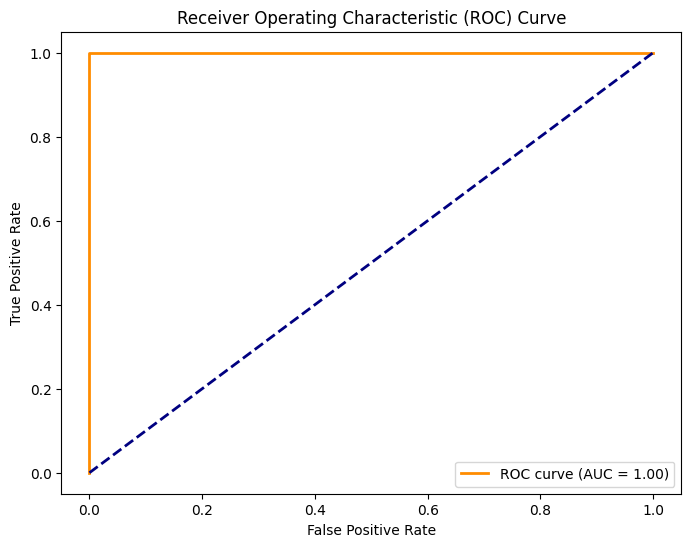

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Inicialización del modelo con class_weight='balanced'
logreg = LogisticRegression(max_iter=100, class_weight='balanced', penalty='l2', C=0.1)

# Entrenamiento
logreg.fit(X_train_scaled, y_train)

# Predicciones
y_pred = logreg.predict(X_test_scaled)
y_pred_prob = logreg.predict_proba(X_test_scaled)[:, 1]  # Probabilidades de la clase positiva

# Resultados
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nAUC Score:", roc_auc_score(y_test, y_pred_prob))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_test, y_pred_prob))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

def train_random_forest(X_train, y_train, X_val, y_val):
    param_grid = {
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True, False]
    }
    forest = RandomForestClassifier(random_state=42, n_estimators=100)
    grid = GridSearchCV(forest, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    best_model.set_params(n_estimators=500)
    y_pred = best_model.predict(X_val)
    y_pred_prob = best_model.predict_proba(X_val)[:, 1]  # Probabilidades para la clase positiva

    # Resultados de clasificación
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    print("\nAccuracy Score:", accuracy_score(y_val, y_pred))
    print("\nAUC Score:", roc_auc_score(y_val, y_pred_prob))

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_val, y_pred_prob))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    return best_model


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1512
           1       1.00      1.00      1.00       574

    accuracy                           1.00      2086
   macro avg       1.00      1.00      1.00      2086
weighted avg       1.00      1.00      1.00      2086


Confusion Matrix:
[[1512    0]
 [   0  574]]

Accuracy Score: 1.0

AUC Score: 1.0


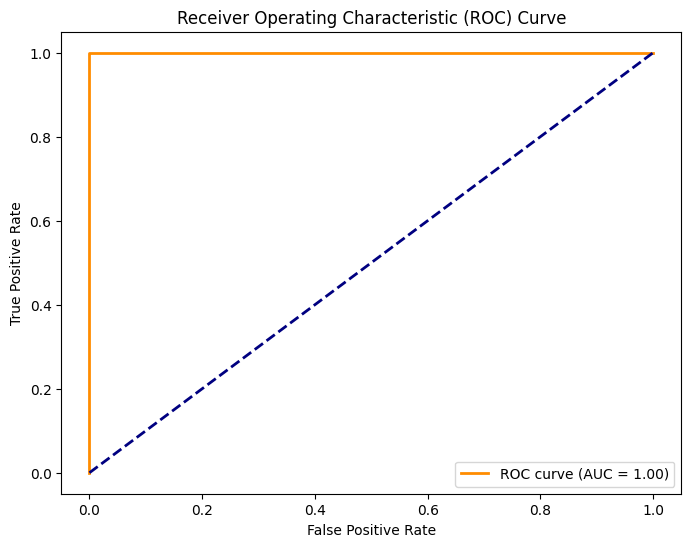

In [66]:
rf_model= train_random_forest(X_train_scaled, y_train, X_test_scaled, y_test)

In [67]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

def train_adaboost(X_train, y_train, X_val, y_val):
    param_grid = {
        'learning_rate': [0.01, 0.1, 1.0]
    }
    ada = AdaBoostClassifier(random_state=42, n_estimators=100)
    grid = GridSearchCV(ada, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    best_model.set_params(n_estimators=500)
    y_pred = best_model.predict(X_val)
    y_pred_prob = best_model.predict_proba(X_val)[:, 1]  # Probabilidades para la clase positiva

    # Resultados de clasificación
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    print("\nAccuracy Score:", accuracy_score(y_val, y_pred))
    print("\nAUC Score:", roc_auc_score(y_val, y_pred_prob))

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_val, y_pred_prob))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    return best_model


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1512
           1       1.00      1.00      1.00       574

    accuracy                           1.00      2086
   macro avg       1.00      1.00      1.00      2086
weighted avg       1.00      1.00      1.00      2086


Confusion Matrix:
[[1512    0]
 [   0  574]]

Accuracy Score: 1.0

AUC Score: 1.0


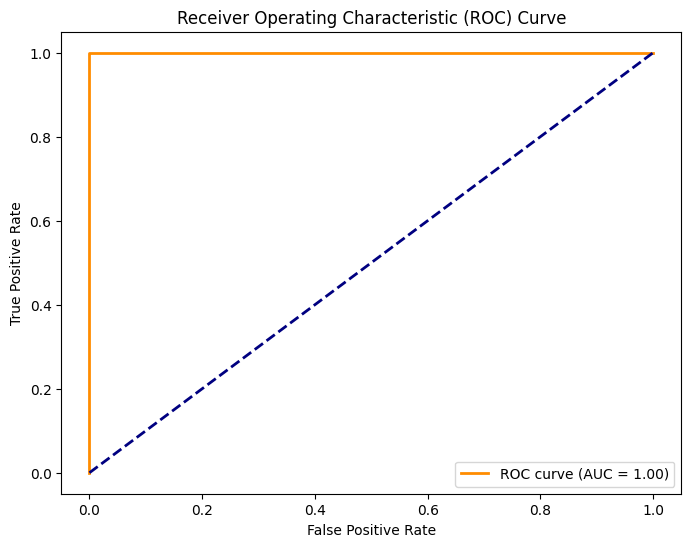

In [68]:
ab_model= train_adaboost(X_train_scaled, y_train, X_test_scaled, y_test)

# Evaluation

Existe overfitting en todos los modelos. Lo mas probable debido a la forma en la que se manejaron los datos.

# Deployment

### 1. **Integración del Modelo en Producción**

* Desarrolla una API o microservicio que permita realizar predicciones en tiempo real.
* Usa frameworks como **Flask** o **FastAPI** para la exposición del modelo.
* Asegúrate de que los datos de entrada sean consistentes con los datos usados en el entrenamiento del modelo.

### 2. **Monitoreo de Deriva de Datos**

* Implementa herramientas como **EvidentlyAI** o **Scikit-Multiflow** para monitorear la deriva de datos.
* Monitorea variables clave como la distribución de características y el rendimiento del modelo en producción (usando métricas como la **AUC** o **accuracy**).
* Establece umbrales de alerta para cuando se detecten cambios significativos en los datos.

### 3. **Estrategia de Descuentos**

* Crea un sistema basado en el comportamiento del cliente y en las predicciones del modelo para ajustar dinámicamente los descuentos.
* Analiza patrones históricos para ajustar precios de forma eficiente utilizando **optimización** o **algoritmos de precios dinámicos**.

### 4. **Mejorar el Manejo de Datos**

* Implementa **tuberías de procesamiento de datos** usando **mage** para automatizar el flujo de datos.

### 5. **Detección de Overfitting y Optimización del Modelo**

* Implementa técnicas de validación cruzada y ajuste de hiperparámetros (usando **GridSearchCV** o **RandomizedSearchCV**) para evitar el overfitting.
* Usa **regularización** (L1/L2) para reducir la complejidad del modelo.
* Monitorea el **error en el entrenamiento y prueba** para detectar posibles problemas de sobreajuste.
